### Overview of the notebook

* [Motivation](#chapter1)

* [Basic statistics](#chapter2)

* [Basic statistics](#chapter3)

* [Discussion](#chapter4)

* [Contributions](#chapter5)

## 1. Motivation <a class="anchor" id="chapter1"></a>

**The motivation:** When we think of Disney films, we feel a rush of nostalgia, as if we were watching one of those with a bowl of cereal on a Sunday morning. Therefore, it was an easy decision to take a further look into the villains of Disney, and explore the characters in a new light.

**The dataset:** The dataset was extracted from the Disney Fandom Wiki webpage, and it contains all the character villains from Dinsey. That includes characters from different universes, e.g Marvel, Pixar, Star Wars, Walt Disney and other. After having built and visualized the network, we decided to narrow the scope and maintaining at least some possibility of analysing information about the dataset, do to lack of internal connections in the whole Disney Villains dataset. We then chose to select a subset of the data, that represents one universe, Marvel. 

**The goal:** The goal of the project was to find somthing interesting in the dataset. 

we thought it would be interesting to to use the text-analysis tools we have learned in the course on quotes. (ATH - KLÁRA) 


### Imports

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import urllib.request
import json
import re
import os
import collections

from fa2 import ForceAtlas2
from matplotlib.lines import Line2D

### Helper functions to get the data

* `load_dataframe`: Reads the csv file, that contails all the villains from disney, and returns a DataFrame.
* `get_path`: Returns the path to the folder that the description txt files are placed.
* `read_data`: Reads the descriptions txt files and returns the description.
* `get_universe`: Finds what universe each villain is a part of. (LAGA)
* `merge_dataframes`: Returns a DataFrame with villains and corresponding universes.
* `get_quotes`: Finds all the quotes each villain has.
* `get_hyperlinks`: Finds all the links that connect the villains together

In [2]:
def load_dataframe(url):
    characters_df = pd.read_csv(url, sep = ';')
    return characters_df

In [3]:
# Get the path for the folder that we keep the descriptions in 
def get_path(name_of_folder):
    script_path = os.getcwd()
    folder = name_of_folder
    path = os.path.join(script_path,folder)
    return path

In [4]:
def read_data(path, char):
    with open(path + char + '.txt', 'r') as f:
        node_description = f.read()
    return node_description

In [5]:
def get_category(characters_df, pat):
    path = get_path('Villains2/')                        
    
    pattern = pat
    
    categories = []
    for char in characters_df.name_of_villains.values:
        # open the description files
        node_description = read_data(path, char)   
        
        find_categories = []
        for p in pattern:
            find_categories += re.findall(p, node_description)
            
        for cat in find_categories:
            categories.append((char, cat))

    return categories

In [6]:
def merge_and_clean_dataframe(col, category, pattern, characters_df):
    df = pd.DataFrame(set(category))
    df['name_of_villains'] = df[0]
    del df[0]
    df[col] = df[1]
    del df[1]
    df_villains_merged = pd.merge(characters_df, df, on='name_of_villains', how='left')
    return df_villains_merged

In [7]:
# Get the quotes in the DataFrame
def get_quotes(df_villains):
    path = get_path('Villains2/')
    
    quotes_pattern = '\{\{Quote\|(.*?)[\[\[(.*?)\]\]]?(?:\|.*?)\}\}'

    quotes = []
    for char in df_villains.name_of_villains.values:
        # open the description files
        node_description = read_data(path, char)
        
        find_quotes = re.findall(quotes_pattern, node_description)
            
        for q in find_quotes:
            quotes.append((char, q))

    return quotes

In [8]:
# Get the hyperlinks
def get_hyperlinks(df_villains):
    path = get_path('Villains2/')
    
    pattern = '\[\[(.*?)(?:\|.*?)?\]\]'
    links = []
    for char in df_villains.name_of_villains.values:
        # open the zelda description files
        node_description = read_data(path, char)
    
        links_square = re.findall(pattern, node_description)
   
        # For pattern including square brackets  
        for name in links_square:
            # check if character is in the char list
            if name in df_villains.name_of_villains.values:
                links.append((char, name))
            else:
                continue
    return links

### Importing dataset

In [9]:
characters_df = load_dataframe('name_of_villains_4ang.csv')

In [10]:
# Get the corresponding universes
universe_pattern = ['\[\[Category:(Marvel) Cinematic Universe characters\]\]',
                        '\[\[Category:(Marvel) Comics\]\]',
                        '\[\[Category:(Marvel) Comics characters\]\]',
                        '\[\[Category:(Pixar) characters\]\]',
                        '\[\[Category:(Disney) characters\]\]',
                        '\[\[Category:(Star Wars) characters\]\]',
                        '\[\[Category:(Star Wars) villains\]\]']

universe = get_category(characters_df, universe_pattern)
characters_df = merge_and_clean_dataframe('Universe', universe, universe_pattern, characters_df)

# If we have a nan value the character has no known universe
characters_df = characters_df.fillna('Unkown')
    
# In the dataframe few characters have two universes
# sort them in a way that dinsney comes first and then delete the duplicates of the first column
# this way the charcters will not belong to disney anymore
characters_df = characters_df.sort_values('Universe')
characters_df = characters_df.drop_duplicates(subset='name_of_villains', keep="last")

In [11]:
# Get the corresponging organizations - to be able to drop the organizations from our dataframe
org_pattern = ['\[\[Category:(Organizations)\]\]']
organization = get_category(characters_df, org_pattern)
characters_df = merge_and_clean_dataframe('Org', organization, org_pattern, characters_df)

In [12]:
# Only keep the characters who are not an organization
characters_df = characters_df[characters_df.Org != 'Organizations']
# Then drop organization column
characters_df = characters_df.drop('Org', 1)

<ipython-input-12-cee47b3d0f40>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  characters_df = characters_df.drop('Org', 1)


In [13]:
characters_df

,name_of_villains,Universe
0,Komodo Dragon,Disney
1,Roger Klotz,Disney
2,Aldrin Klordane,Disney
3,Captain Klegghorn,Disney
4,Sirocco,Disney
...,...,...
2761,Trantor,Unkown
2762,Olivier Trajean,Unkown
2763,Giant Magnet,Unkown
2764,Texie Garcia,Unkown


In [14]:
links = get_hyperlinks(characters_df)

## 2. Basic statistics <a class="anchor" id="chapter2"></a>

Let's examine some basic statistic before we go further into preprocessing the data. This includes:

* Number of disney villains that are in the dataset
* Number of directed links
* Number of different universes that are extracted from the text analysis

In [15]:
print('There are', len(characters_df), 'Disney villains,', len(links), 'directed links and', 
      len(set(characters_df['Universe'])), 'different universes in our dataset')

There are 2738 Disney villains, 9874 directed links and 5 different universes in our dataset


### 2.1 Cleaning and pre-processing the data

In [16]:
for name in list(characters_df['name_of_villains'].values):
    path = get_path('Villains2/')
    node_description = read_data(path, name)     
    
    node_description = re.sub(r"External links==(.*?)\\n\[\[Category", " ", node_description)
    node_description = re.sub(r"Gallery==(.*?)\<\/gallery\>\\n\\n", " ", node_description)
    node_description = re.sub(r"(\{\{.*?)'''", " ", node_description)    # remove infobox   
    node_description = re.sub(r"\{\{(.*?)\}\}", " ", node_description)  # remove curly brackets (links and citations)
    node_description = re.sub(r"==(==.*?==)==", " ", node_description)   # remove titles and chapter breaks
    node_description = re.sub(r"(==.*?==)", " ", node_description)       # remove paragraphs
    node_description = re.sub(r"(\[\[Category:.*?\]\])", " ", node_description)   #   remove categories links
    node_description = re.sub(r"(\<\/?ref.*?>)", " ", node_description)      # remove references citations (small numbers)
    node_description = re.sub(r"(\[\[File.*?\|thumb\|.*?\]\])", " ", node_description) #  remove images
    node_description = re.sub(r"(\\n)", " ", node_description)         # leave space/change line
    node_description = re.sub(r"\W+", " ", node_description)
    node_description = re.sub(r"\s(one|two|later)\s", " ", node_description)   # remove specific recurrent words, that appear too often
    node_description = re.sub(r"\\s+", " ", node_description)       # replace multiple spaces with one
    
    
    
    path = get_path('Clean_text/')
    with open(path + name + '.txt', 'w') as file:
        json.dump(node_description, file)

### 2.2 Discussion of dataset statistics

#### Features of the network

To get a sense of the data that we are working with, let's look at the entier network and its features. To visualize this, we decided to create a random network with the same amount of nodes and edges as the whole villains network. This was done to compare the degree distribution and check if our intuitions about what we should observe is correct.

In [17]:
# Make a network
villians_network = nx.DiGraph()

# Add egdes
villians_network.add_edges_from(links)

# Discard isolated nodes
villians_network.remove_nodes_from(list(nx.isolates(villians_network)))

In [18]:
# Extract the giant connected component
gcc = villians_network.subgraph(max(nx.weakly_connected_components(villians_network), key=len))

In [19]:
# Lenght of nodes and edges, and the value of p (probability for edge creation)
gcc_nodes = len(gcc.nodes)
gcc_edges = len(gcc.edges)
p = gcc_edges/(gcc_nodes*(gcc_nodes-1))

In [20]:
random_network = nx.fast_gnp_random_graph(gcc_nodes, p, directed=True)

In [21]:
# Find the in and out degree for the villains network
degree_in = list(dict(gcc.in_degree()).values())
degree_out = list(dict(gcc.out_degree()).values())
# Find the degree for the random network
degree_random = list(dict(random_network.degree()).values())

In [22]:
# Find the count of the degrees
degree_count_in = pd.Series(degree_in).value_counts()
degree_count_out = pd.Series(degree_out).value_counts()
degree_count_random = pd.Series(degree_random).value_counts()

In [23]:
# Find the top 5 in-degree
top_indegree = sorted(dict(gcc.in_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 in-degree of the Villains network:\n', top_indegree[:5], '\n')
# Find the top 5 out-degree
top_outdegree = sorted(dict(gcc.out_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 out-degree of the Villains network:\n', top_outdegree[:5])

Top 5 in-degree of the Villains network:
 [('Captain Hook', 79), ('Pete', 73), ('Maleficent', 69), ('Hades', 62), ('Jafar', 59)] 

Top 5 out-degree of the Villains network:
 [('Captain Hook', 33), ('Cruella De Vil', 31), ('The Evil Queen', 30), ('Maleficent', 30), ('Hades', 29)]


Above we can see the villains that have the highest in- and out-degree. We notice that the highest in-degree is not significant high, compared to the number of nodes in the network.

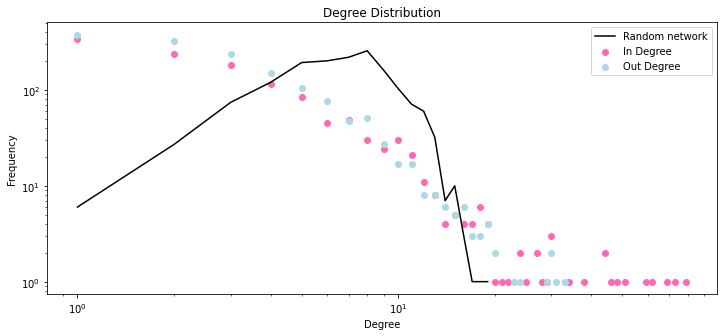

In [24]:
# Plot the in degree, out degree and random network degree
plt.figure(figsize=(12,5))
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
ind = plt.scatter(degree_count_in.index, degree_count_in, color='HotPink')
outd = plt.scatter(degree_count_out.index, degree_count_out, color='lightblue')
rand_argsort = np.argsort(degree_count_random.index)
totd = plt.plot(degree_count_random.index[rand_argsort], degree_count_random.iloc[rand_argsort], color='black')
plt.legend(['Random network','In Degree', 'Out Degree',])
plt.xscale('log')
plt.yscale('log')
plt.show()

From the figure, we see that the in-degree distribution looks a lot like a scale free network, when seen on the log-log plot. Although it is very different from the random network, we also see a slight curve in the distribution so it doesn't perfectly follow a power-law distribution, and therefore we can't declare it as a scale free network. When we look at the out-degree, we see that it is very similar to the in-degree distribution. This is reasonable since the connections in the whole villains network are very sparse, and the charcters have similar amount of in- and out-degree, which encourages us to look further into a specific universe inside the whole villains network. 

Let’s visualize the villains network and see how the connections in between the universes are. 

In [25]:
# Get node positions based on the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # Log
                          verbose=False)

In [26]:
gcc_undirected = gcc.to_undirected()

In [27]:
degrees = [val for node,val in gcc_undirected.degree()]

# Scale node size according to degree
node_size = [i * 1.6 for i in degrees]

In [28]:
# Get color nodes according to the universe
marvel_df = characters_df.loc[(characters_df['Universe'] == 'Marvel')]
star_wars_df = characters_df.loc[(characters_df['Universe'] == 'Star Wars')]
pixar_df = characters_df.loc[(characters_df['Universe'] == 'Pixar')]
disney_df = characters_df.loc[(characters_df['Universe'] == 'Disney')]
unkown_df = characters_df.loc[(characters_df['Universe'] == 'Unkown')]

color_roles = []
for node in gcc_undirected.nodes():
    if node in marvel_df.name_of_villains.values:
        color_roles.append('#00FF00')
    elif node in star_wars_df.name_of_villains.values:
        color_roles.append('#FF0000')
    elif node in pixar_df.name_of_villains.values:
        color_roles.append('#000000')
    elif node in disney_df.name_of_villains.values:
        color_roles.append('#04D8B2')
    elif node in unkown_df.name_of_villains.values:
        color_roles.append('#FF7F50')

In [29]:
edge_colors = []
for u, v in gcc_undirected.edges():
    edge_colors.append("#C0C0C0")

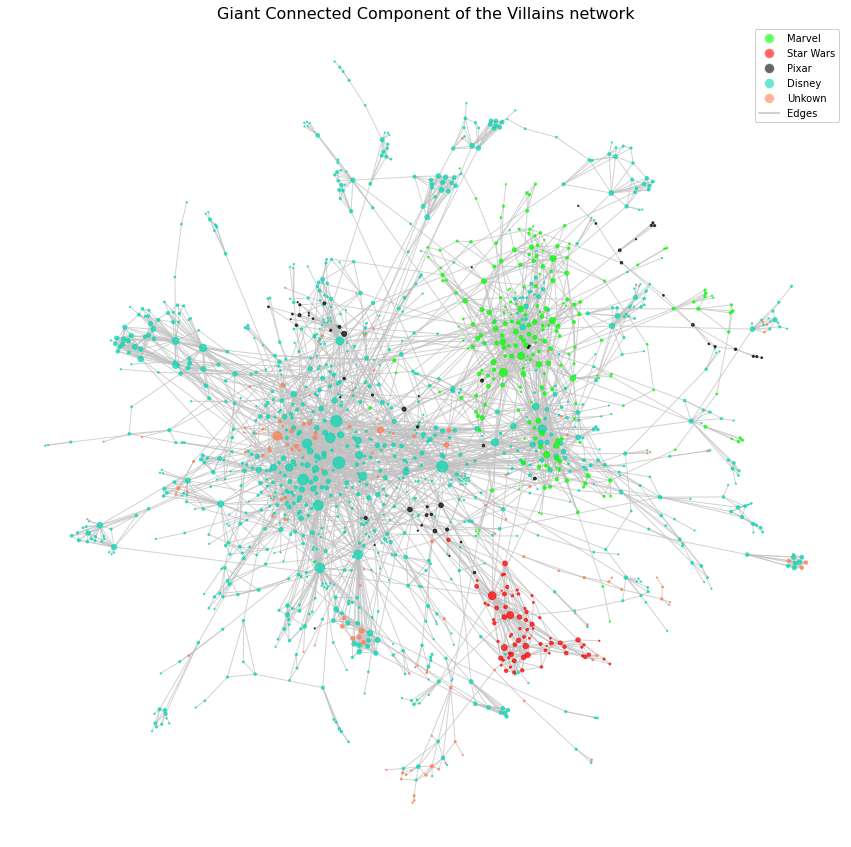

In [30]:
f = plt.figure(figsize=(15,15))
ax = plt.gca()

# Create a legend for the different colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Marvel',
                          markerfacecolor="#00FF00", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Star Wars',
                          markerfacecolor="#FF0000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Pixar',
                          markerfacecolor="#000000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Disney',
                          markerfacecolor="#04D8B2", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Unkown',
                          markerfacecolor="#FF7F50", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C0C0C0", label='Edges')]

positions = forceatlas2.forceatlas2_networkx_layout(gcc_undirected, pos=None, iterations=50)
nodes = nx.draw_networkx_nodes(gcc_undirected, positions, node_size=node_size, node_color=color_roles, alpha=0.7)
edges = nx.draw_networkx_edges(gcc_undirected, positions, edge_color=edge_colors,alpha=0.7)

plt.axis('off')
plt.title("Giant Connected Component of the Villains network", fontsize=16)

plt.legend(handles=legend_elements, facecolor='white', framealpha=1)

plt.show()

The figure above shows the whole Villains network, with different colors for all the five universes. On the figure we see that there are some groups that are better connected than others. Those groups represent the different universes. The Marvel universe is displayed with green color, Star Wars with red color, Pixar with gray color, Walt diseny with blue color and the villains who are not a part of a specific universe, are represented with pink color (Unknown). When looking at the graph, we see that the green nodes make a large, separated group, and we are interested in exploring that further.

In [31]:
# Make a network
marvel_network = nx.DiGraph()

# Add egdes
marvel_links = get_hyperlinks(marvel_df)
marvel_network.add_edges_from(marvel_links)

# Discard isolated nodes
marvel_network.remove_nodes_from(list(nx.isolates(marvel_network)))

In [32]:
# Extract the giant connected component
gcc_marvel = marvel_network.subgraph(max(nx.weakly_connected_components(marvel_network), key=len))

In [33]:
gcc_undirected_marvel = gcc_marvel.to_undirected()

In [34]:
degrees = [val for node,val in gcc_undirected_marvel.degree()]

# Scale node size according to degree
node_size = [i * 1.6 for i in degrees]

In [35]:
# Get color for Marvel nodes 
color_roles = []

for node in gcc_undirected_marvel.nodes():
    if node in marvel_df.name_of_villains.values:
        color_roles.append('#00FF00')

In [36]:
edge_colors = []
for u, v in gcc_undirected_marvel.edges():
    edge_colors.append("#C0C0C0")

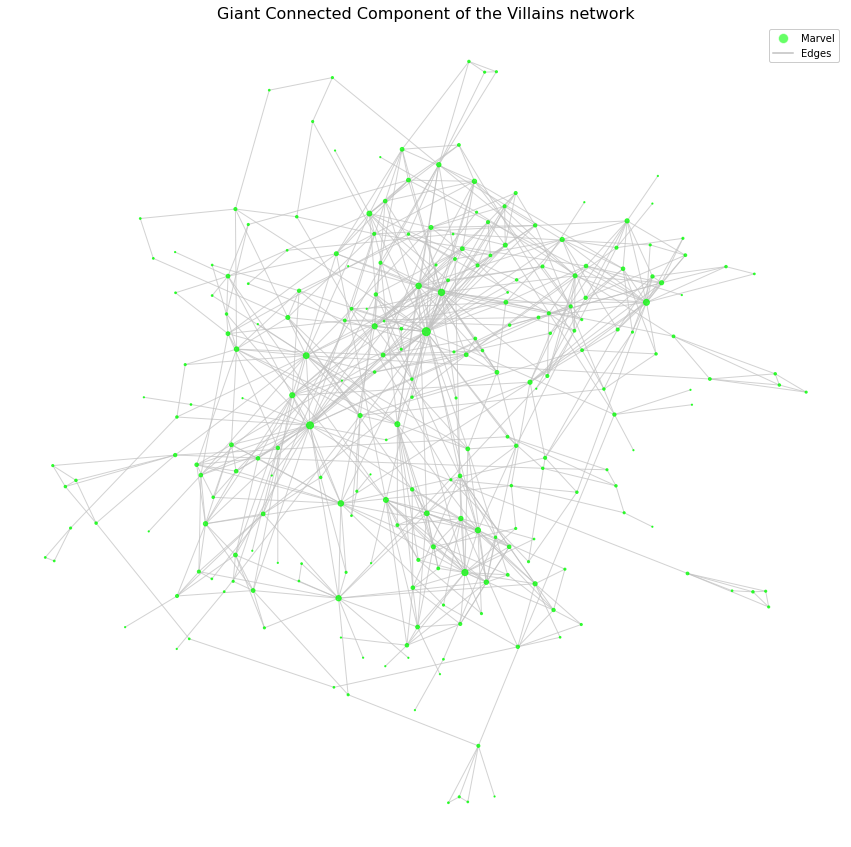

In [37]:
# Plot the Marvel network
f = plt.figure(figsize=(15,15))
ax = plt.gca()

# Create a legend for the different colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Marvel',
                          markerfacecolor="#00FF00", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C0C0C0", label='Edges')]

positions = forceatlas2.forceatlas2_networkx_layout(gcc_undirected_marvel, pos=None, iterations=50)
nodes = nx.draw_networkx_nodes(gcc_undirected_marvel, positions, node_size=node_size, node_color=color_roles, alpha=0.7)
edges = nx.draw_networkx_edges(gcc_undirected_marvel, positions, edge_color=edge_colors,alpha=0.7)

plt.axis('off')
plt.title("Giant Connected Component of the Villains network", fontsize=16)

plt.legend(handles=legend_elements, facecolor='white', framealpha=1)

plt.show()

In [38]:
# Find the top 5 in-degree
top_indegree_marvel = sorted(dict(gcc_marvel.in_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 in-degree of the Villains network:\n', top_indegree_marvel[:5], '\n')
# Find the top 5 out-degree
top_outdegree_marvel = sorted(dict(gcc_marvel.out_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 out-degree of the Villains network:\n', top_outdegree_marvel[:5])

Top 5 in-degree of the Villains network:
 [('Loki Laufeyson', 32), ('Thanos', 30), ('Grant Ward', 21), ('Baron Zemo', 20), ('Doctor Octopus', 18)] 

Top 5 out-degree of the Villains network:
 [('Loki Laufeyson', 23), ('Grant Ward', 20), ('Thanos', 18), ('Gideon Malick', 16), ('The Other', 15)]


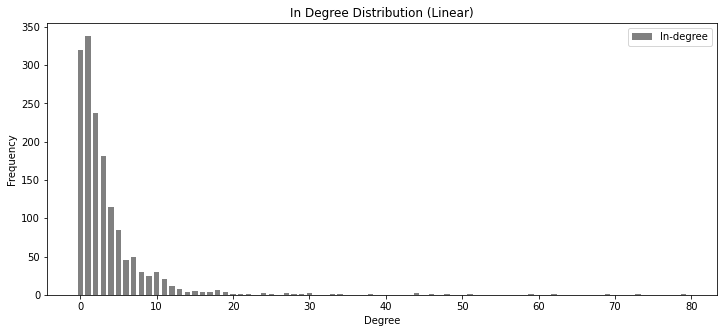

In [39]:
# Plotting the in-degree distribution
degree = sorted([d for n, d in gcc.in_degree()])
degree_count = collections.Counter(degree)
deg, count = zip(*degree_count.items())

# With linear axes
plt.figure(figsize=(12,5))
plt.bar(deg, count, width=0.7, color="grey")
plt.title("In Degree Distribution (Linear)")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend(['In-degree'])

plt.show()

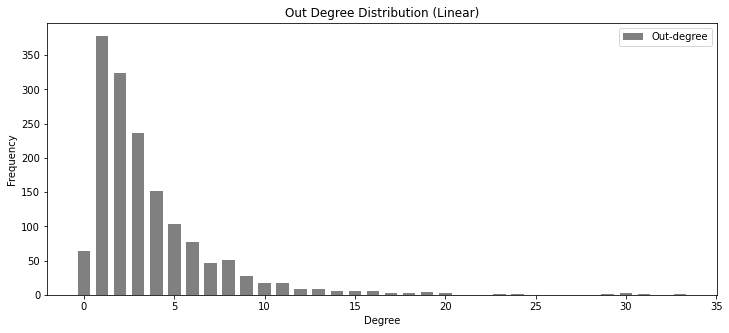

In [40]:
# Plotting the out-degree distribution
degree = sorted([d for n, d in gcc.out_degree()])
degree_count = collections.Counter(degree)
deg, count = zip(*degree_count.items())

# With linear axes
plt.figure(figsize=(12,5))
plt.bar(deg, count, width=0.7, color="grey")
plt.title("Out Degree Distribution (Linear)")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend(['Out-degree'])

plt.show()

## wordclouds

In [ ]:
characters_df

### Tools, theory and analysis <a class="anchor" id="chapter3"></a>

In [129]:
# CREATE LIST OF CHARACTERS
universe_list = list(set(characters_df['Universe']))
list_of_names = characters_df['name_of_villains'].tolist()

In [172]:
list_of_names

['Komodo Dragon',
 'Roger Klotz',
 'Aldrin Klordane',
 'Captain Klegghorn',
 'Sirocco',
 'Thaddeus E. Klang',
 'Kizin',
 'Kit Cactus',
 'Kismet',
 'Kip Killian',
 'Sista Spice',
 'Ricky King',
 'King Zongo',
 'King Runeard',
 'King Andrias',
 'The King and the Duke',
 'The Skeleton King',
 'The King',
 'Skeleton Pirate Captain',
 'Killjoy Margaret',
 'Duff Killigan',
 'Skeleton Pirates',
 'Skeletons',
 'Killbot 86',
 'Susan Skidmore',
 'Kileem',
 'Kikimora',
 'Khnum',
 'Klutzy',
 'Knave of Hearts',
 'Knight Mare',
 'Knights of Destruction',
 'Kronos',
 'Kronin',
 'Kron',
 'Gyrus Krinkle',
 'Krinkle',
 'Silverado Brothers',
 'Anne Krell',
 'Garrett Krebs',
 'Helga Sinclair',
 'Neville Sinclair',
 'Dr. Ivan Krank',
 'Kylie Kramer',
 'Kramer',
 'Khartoum',
 'The Kraken',
 'Kragthar',
 'Kraggler',
 'Krackenstein',
 'Dr. Kozak',
 'Winston Kotter',
 'Singular',
 'The Sinister Sisters',
 'Zutho',
 'Kojak',
 'Koehler',
 'Knights of Vengeance',
 'Sirenia',
 'Kraken',
 'Mr. Kroop',
 'Shere Khan'

In [130]:
universe_list

['Marvel', 'Unkown', 'Star Wars', 'Pixar', 'Disney']

In [131]:
# convert the file names
normal_name = []
comp_name = []
list_of_names = characters_df['name_of_villains'].tolist()
for name in list_of_names:
    if ' ' in name:
        comp_name.append(name)
    else:
        normal_name.append(name)


In [136]:
from nltk.corpus import stopwords

In [171]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

def get_tokenized_dict(characters_df, column, list_of_column):
    dict_of_universes = {}
    for uni in list_of_column:
        final_list = []
        df = characters_df[characters_df[column] == uni] # svo ég þurfi ekki að loopa í gegnum allt, heldur bara þegar name samsvarar raceinu sem ég er staðsett í
        for char in df['name_of_villains']:
        
            with open(path + char + '.txt', 'r', encoding="utf-8") as file:
                content = file.read()
        
            char = char.replace(' ','_')    
    
            # hér remove-a composite names -> áður en við tonkenizum
            for name in comp_name:
                content = content.replace(name, "")
        
            tk = RegexpTokenizer(r'\w+') # nota þennan tokenizer til þess að geta removeað punktuation á auðveldan hátt
            token_content = tk.tokenize(content)
    
            # hér remove-a normal names
            words = [word for word in token_content if word not in normal_name]
    
            # setja allt i lower case
            words = [word.lower() for word in words]

            # remove-a stop words
            words = [word for word in words if word not in stopwords.words('english')]

            # remove tokens containing numbers
            words = [x for x in words if not any(c.isdigit() for c in x)]

            wnl = WordNetLemmatizer()
            words = [wnl.lemmatize(word) for word in words]

            final_list.extend(words) # passa að yfirskrifa ekki!!!
        dict_of_universes[uni] = final_list
    return dict_of_universes

In [166]:
get_tokenized_dict(characters_df, 'Universe', universe_list)

{'Marvel': ['marvel',
  'comic',
  'character',
  'supervillain',
  'appeared',
  'ultimate',
  'spider',
  'voiced',
  'ashley',
  'eckstein',
  'exposed',
  'energy',
  'darkforce',
  'dimension',
  'gained',
  'ability',
  'control',
  'sound',
  'ability',
  'generate',
  'fear',
  'anger',
  'sadness',
  'ability',
  'control',
  'mind',
  'telepathy',
  'ability',
  'fly',
  'decided',
  'use',
  'power',
  'supervillain',
  'try',
  'take',
  'new',
  'york',
  'city',
  'kill',
  'spider',
  'marvel',
  'cinematic',
  'universe',
  'marvel',
  'comic',
  'character',
  'antagonist',
  'former',
  'member',
  'nova',
  'corp',
  'currently',
  'leader',
  'force',
  'member',
  'nova',
  'corp',
  'betrayed',
  'point',
  'formed',
  'alliance',
  'discovered',
  'remaining',
  'nova',
  'helmet',
  'earth',
  'wielded',
  'sam',
  'alexander',
  'sent',
  'force',
  'retrieve',
  'fought',
  'spider',
  'helping',
  'nova',
  'guardian',
  'galaxy',
  'defeated',
  'nova',
  't

In [141]:
dict_of_universes

{'Marvel': ['marvel',
  'comic',
  'character',
  'supervillain',
  'appeared',
  'ultimate',
  'spider',
  'voiced',
  'ashley',
  'eckstein',
  'exposed',
  'energy',
  'darkforce',
  'dimension',
  'gained',
  'ability',
  'control',
  'sound',
  'ability',
  'generate',
  'fear',
  'anger',
  'sadness',
  'ability',
  'control',
  'mind',
  'telepathy',
  'ability',
  'fly',
  'decided',
  'use',
  'power',
  'supervillain',
  'try',
  'take',
  'new',
  'york',
  'city',
  'kill',
  'spider',
  'marvel',
  'cinematic',
  'universe',
  'marvel',
  'comic',
  'character',
  'antagonist',
  'former',
  'member',
  'nova',
  'corp',
  'currently',
  'leader',
  'force',
  'member',
  'nova',
  'corp',
  'betrayed',
  'point',
  'formed',
  'alliance',
  'discovered',
  'remaining',
  'nova',
  'helmet',
  'earth',
  'wielded',
  'sam',
  'alexander',
  'sent',
  'force',
  'retrieve',
  'fought',
  'spider',
  'helping',
  'nova',
  'guardian',
  'galaxy',
  'defeated',
  'nova',
  't

convert dictionary to df

In [142]:
#create dataframe from dictionary to use for the wordcloud
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in dict_of_universes.items() })
dict_df = dict_df.T

# merge all columns with strings to one column with all the strings
df_w = pd.Series(dict_df.fillna('').values.tolist()).str.join(' ')
df_w = df_w.to_frame()

df_w['universe'] = universe_list
df_w = df_w.rename(columns={0: 'description'})

In [ ]:
import wordcloud
# Define wordcloud function to use for each of the races
def show_wordcloud(df_w, title):
    text = ' '.join(df_w['description'].astype(str).tolist())   #
    #crete list of strings
    stopwords = set(wordcloud.STOPWORDS) #set stopwords, taken from library
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color="white").generate(text)
    #nr of words included, size of biggest word etc..
    plt.figure(figsize=(10,6), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.show()

In [ ]:
show_wordcloud(df_w[df_w.universe=='Marvel'], "Marvel Wordcloud")
show_wordcloud(df_w[df_w.universe=='Disney'], "Disney Wordcloud")
show_wordcloud(df_w[df_w.universe=='Pixar'], "Pixar Wordcloud")
show_wordcloud(df_w[df_w.universe=='Unkown'], "Unkown Wordcloud")
show_wordcloud(df_w[df_w.universe=='Star Wars'], "Star Wars Wordcloud")

## COMMUNITIES IN MARVEL

In [ ]:
#marvel_undir = gcc_marvel.to_undirected()

In [143]:
import community
# 1. DEFINE THE COMMUNITIES
def communities(graph):
    partition = community.best_partition(graph)
    d = collections.defaultdict(list)
    # the community.best_partition function maps nodes to a community number, below we map 
    for com in set(partition.values()):
        for nodes in partition.keys():
            if partition[nodes] == com:
                d[com].append(nodes)
    
    return list(d.values())

In [144]:
marvel_communities = communities(gcc_undirected_marvel)

In [145]:
marvel_communities = communities(gcc_undirected_marvel)

In [146]:
community_names = [", ".join(sorted([node for node in com], key=lambda x: gcc_marvel.degree(x), reverse=True)[:3]) for com in marvel_communities]

In [147]:
print('There are', len(community_names), 'communities in total')

There are 11 communities in total


In [149]:
pd.DataFrame(community_names)


,0
0,"Thanos, Kree, Chitauri"
1,"Baron Zemo, Red Skull, Amora the Enchantress"
2,"Grant Ward, Gideon Malick, Baron Strucker"
3,"Ultron, Scarlet Witch, Quicksilver"
4,"Doctor Octopus, Venom, Harry Osborn"
5,"Loki Laufeyson, Asgardians, Variants"
6,"Doctor Spectrum, Nighthawk, Power Princess"
7,"M.O.D.O.K., Leader, Grandmaster"
8,"Aldrich Killian, Eric Savin, Ellen Brandt"
9,"Dormammu, Kaecilius, Zealots"


In [187]:
communities

<function __main__.communities(graph)>

## statistics in marvel

In [65]:
import networkx as nx

In [66]:
nx.density(gcc_marvel)

0.016457537734133477

The graph is not strongly connected so there is not a diameter

In [ ]:
#nx.diameter(gcc_marvel)

In [110]:
# (d) Average shortest path
nx.average_shortest_path_length(gcc_marvel)


3.219167121294781

In [111]:
# (e) print information on edges, nodes...
print(nx.info(gcc_marvel))

Name: 
Type: DiGraph
Number of nodes: 235
Number of edges: 905
Average in degree:   3.8511
Average out degree:   3.8511


In [70]:
nx.average_shortest_path_length(gcc_marvel)

3.219167121294781

In [103]:
# clustering coefficients and cliques

In [85]:
# clustering coefficient returns the value of 1 when all the neighbours of the node are connected to each other
import operator
x = nx.clustering(gcc_marvel)
clust = dict( sorted(x.items(), key=operator.itemgetter(1),reverse=True))

In [87]:
clust_subset = {key: value for key, value in clust.items() if value == 1}
clust_subset

{'Vice President Rodriguez': 1.0,
 'Director Hayward': 1.0,
 'Ellen Brandt': 1.0,
 'Kebo': 1.0,
 'Christian Ward': 1.0,
 'Shades': 1.0,
 'Ymir': 1.0,
 "W'Kabi": 1.0,
 'Sinara': 1.0,
 'Kasius': 1.0,
 'Firelord': 1.0,
 'Melissa Tarleton': 1.0,
 'Lou Tarleton': 1.0,
 'Lucian Aster': 1.0,
 'Nuke': 1.0}

In [102]:
for c in clust_subset:
    [n for n in gcc_marvel[c]]
    print(c, list(gcc_marvel[c].keys()))

Vice President Rodriguez ['Aldrich Killian', 'Eric Savin']
Director Hayward ['Scarlet Witch']
Ellen Brandt ['Aldrich Killian', 'Eric Savin']
Kebo ['Grant Ward', 'Gideon Malick', 'Werner von Strucker']
Christian Ward ['Grant Ward', 'Glenn Talbot']
Shades ['Diamondback', 'Cottonmouth', 'Black Mariah']
Ymir ['Frost Giants', 'Loki Laufeyson']
W'Kabi ['Erik Killmonger', 'Ulysses Klaue']
Sinara ['Kree', 'Kasius']
Kasius ['Sinara', 'Kree']
Firelord ['Galactus']
Melissa Tarleton ['M.O.D.O.K.', 'Jodie Tarleton', 'Lou Tarleton']
Lou Tarleton ['M.O.D.O.K.', 'Jodie Tarleton', 'Melissa Tarleton']
Lucian Aster ['Kaecilius', 'Dormammu']
Nuke ['Nighthawk', 'Power Princess', 'Doctor Spectrum']


In [104]:
# In every line above, all the characters are connected with each other, therefore forming cliques

BETWEENESS CENTRALITY

the fraction of all shortest paths in the network passing through the edge/node for which it is calculated

Higher in betweeness centrality means that more shortest paths pass through the node, which means that more information passes through that character


In [106]:
from collections import Counter, OrderedDict

def get_top_centrality(G, func, top_n=10):
    degree_cent = func(G)
    degree_cent_ordered = OrderedDict(sorted(degree_cent.items(), 
                                             reverse=True, 
                                             key=lambda x: x[1])[:top_n])
    return degree_cent_ordered

In [107]:
bc_cent = get_top_centrality(gcc_marvel, nx.betweenness_centrality)

In [108]:
bc_cent

OrderedDict([('Thanos', 0.26654758104695286),
             ('Loki Laufeyson', 0.15490414284811332),
             ('Ultron', 0.12638675324287987),
             ('Glenn Talbot', 0.10696105353955733),
             ('Doctor Octopus', 0.09200180534548125),
             ('Grant Ward', 0.07855299866434154),
             ('Kree', 0.0675619317079202),
             ('Baron Zemo', 0.06487881548780863),
             ('Red Skull', 0.06368685213436998),
             ('Holden Radcliffe', 0.05626027965873972)])

In [114]:
nx.density(gcc_marvel)

0.016457537734133477

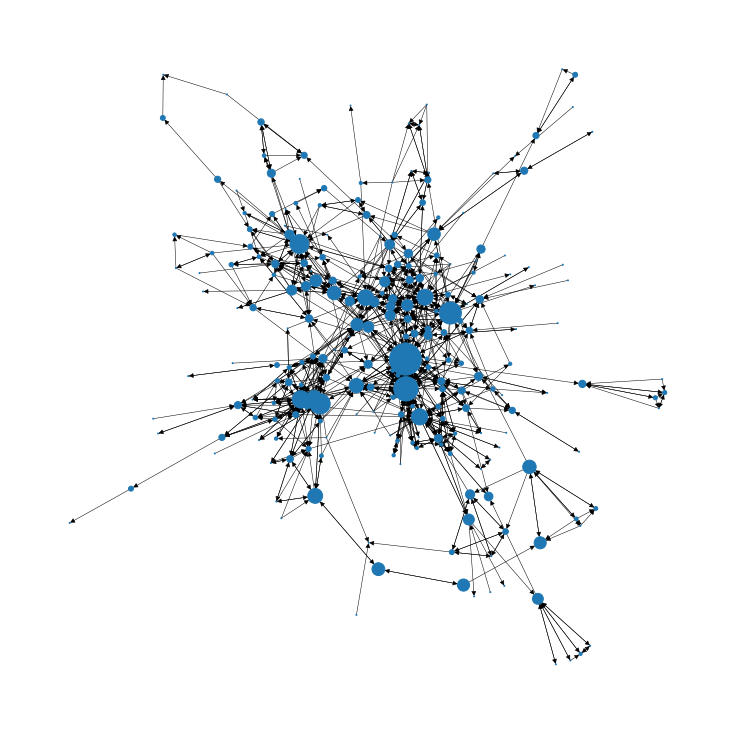

In [115]:
#plot the betweeness centrality
bc_cent_all = get_top_centrality(gcc_marvel, nx.betweenness_centrality, len(gcc_marvel.nodes()))
pos = nx.spring_layout(gcc_marvel.to_undirected(), k=.1)

nodelist = list(bc_cent_all.keys())
node_size = [v for v in bc_cent_all.values()]
bc_max = node_size[0]
node_size = [1000 * v / bc_max + 10 if v > 0 else 1 for v in node_size]

plt.figure(figsize=(10, 10))
nx.draw(gcc_marvel, pos=pos, width=0.5,
    nodelist=nodelist, node_size=node_size
)
plt.show()

##  Sentiment analysis

In [150]:
# Download the LabMT words of happines dataset
url = "https://ndownloader.figstatic.com/files/360592"
words_of_happiness = pd.read_csv(url, delimiter="\t", skiprows=3)

In [151]:
# Import VADER sentiments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [173]:
dict_of_chars = get_tokenized_dict(characters_df, 'name_of_villains', list_of_names)

In [1]:
dict_of_chars

NameError: name 'dict_of_chars' is not defined

In [175]:
def compute_average_sentiment(tokens):

    sentiment = 0.0
    if not len(tokens):
        return sentiment

    avg = np.nan_to_num(words_of_happiness[words_of_happiness["word"].isin(tokens)]["happiness_average"].mean())
    return avg

In [176]:
# The sentiment for each character is given as follows
sentiment_values = {}
for name, val in dict_of_chars.items():
    sentiment_values[name] = compute_average_sentiment(val)

In [177]:
# calculate the average of the average sentiment values
community_average = {}
for i, com in enumerate(marvel_communities):
        community_average[community_names[i]] = np.mean([sentiment_values.get(node, 0.0) for node in com])

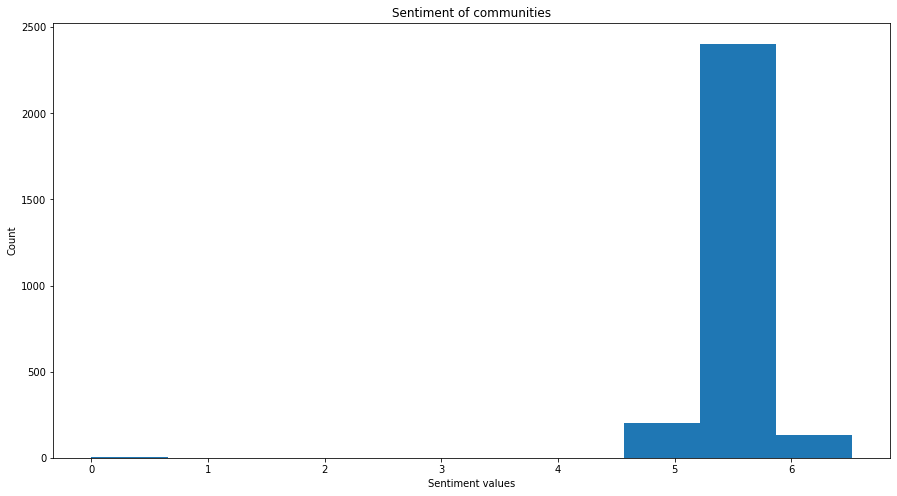

In [179]:
plt.figure(figsize = (15,8))
plt.hist(sentiment_values.values())

plt.title("Sentiment of communities")
plt.ylabel("Count")
plt.xlabel("Sentiment values")
plt.show()

In [188]:
# Convert dictionary to dataframe
sentiment_df = pd.DataFrame({ key:pd.Series(value) for key, value in sentiment_values.items() }).T
sentiment_df = sentiment_df.sort_values(by=[0])

In [189]:
# Happiest
sentiment_df.tail(10)

,0
Three-Headed Troll,6.293333
Bellhops,6.293333
Pig King,6.298182
Meatdripper,6.307619
Bitter Flower,6.312000
Mr. Collinsworth,6.328889
The Hermit,6.340000
Harry Dickens,6.390000
Jester Hole,6.440000
Les Camembert,6.525000


In [190]:
# saddest
sentiment_df.head(10)

,0
The Mandarin,0.000000
Helius Inflato,0.000000
Mole (Bonkers),3.703333
The Rhinoceros and the Bird,4.548571
The Blank,4.587368
Gerry,4.611111
Miss Millipede,4.673077
Candace Adams,4.696667
Basilisco,4.700000
L.C. Clench,4.720000


### Discussion <a class="anchor" id="chapter4"></a>

### Contributions <a class="anchor" id="chapter5"></a>